# Topic Modeling

> Interpretation

In [1]:
# !git clone https://github.com/UrbanResiliencyInitiative/lang-of-pol.git lang-of-pol-repo
# !pip install wordcloud
# !conda install gensim

In [4]:
import numpy as np
import pandas as pd
import nltk
import re
from wordcloud import WordCloud, ImageColorGenerator
import gensim
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns

/Users/shiyang/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
numwords = ['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', \
                 'SIX', 'SEVEN', 'EIGHT', 'NINE', 'TEN', \
                 'ELEVEN', 'TWELVE', 'THIRTEEN', 'FOURTEEN', \
                 'FIFTEEN', 'SIXTEEN', 'SEVENTEEN', 'EIGHTEEN', \
                 'NINETEEN', 'TWENTY', 'THIRTY', 'FORTY', \
                 'FIFTY', 'SIXTY', 'SEVENTY', 'EIGHTY', \
                 'NINETY', 'ZERO']

stopword_list = ['ON', 'THE', 'A', 'AND', 'UH', 'IN', 'TO', 'AT', 'THAT', 'FOR', 'IS', 'WITH', 'OF', 'OH', 'ARE',
                 'THIS', 'IF', 'S', 'I', 'IT']

indicators = ['GUN']

In [6]:
text = pd.read_csv('transcript_files.csv', usecols=['offset', 'duration', 'transcripts'])

In [7]:
def combination(by: list, string: str):
    """
    return a list of number combination
    """
    words = string.split(' ')
    comb_list = []
    comb = []
    for i in range(len(words)):
        if words[i] in by:
            comb.append(words[i])
            comb_list.append(tuple(comb.copy()))
        elif words[i] not in by:
            comb = []
    return comb_list

In [8]:
comb_dict = {}
for index, row in text.iterrows():
    _ = combination(indicators, row['transcripts'])
    for comb in _:
        if comb in comb_dict.keys():
            comb_dict[comb].append(row['transcripts'])
        else:
            comb_dict[comb] = [row['transcripts']]

In [9]:
comb_dict

{('GUN',): ['SIMULCAST IS NOT AVAILABLE FOR A PERSON WITH A GUN THIRTY NINE EIGHTEEN WEST MONTROSE, THREE NINE ONE EIGHT WEST MONTROSE',
  'CALLER CLAIMS THE SISTER PULLED A GUN ON HER',
  'YOU WANNA START RIDING ON THAT SHE SAID SHE SAID CLEVELAND CALLED FIRST SAYING FEMALE NEEDS TO GO SHE’S HIGH AND THE FEMALE CALLED MS. WIGGINS SAYING THAT HER EX-BOYFRIEND CHOKED HER AND HAS A BB GUN THIRTY FOUR O SEVEN SUNNYSIDE THREE FOUR O SEVEN ON SUNNYSIDE',
  "TOMOCAST IS NOT AVAILABLE SEVENTEEN TWENTY THREE ROBERT UNITS IN SEVENTEEN ON THE CITY ON THE ZONE. GOT A PERSON WITH A GUN ITS THIRTY SEVEN THIRTY WEST LELAND THREE SEVEN THREE ZERO LELAND MALE BLACK WITH A WHITE T-SHIRT ON. HE'S IN FRONT WITH A GUN THREATENING PEOPLE",
  "TOMOCAST IS NOT AVAILABLE SEVENTEEN TWENTY THREE ROBERT UNITS IN SEVENTEEN ON THE CITY ON THE ZONE. GOT A PERSON WITH A GUN ITS THIRTY SEVEN THIRTY WEST LELAND THREE SEVEN THREE ZERO LELAND MALE BLACK WITH A WHITE T-SHIRT ON. HE'S IN FRONT WITH A GUN THREATENING PEOPL

In [199]:
def words_heat_map(comb: tuple, transcripts: list):
    """
    plot the heatmap of the transcripts that include a specific code
    light cell means high probability of co-occurance
    """
    empty_map = np.zeros((len(long_text), len(long_text)))
    
    transcrip = ' '.join(transcripts)
    transcrip = [word.replace('<X>', '').replace('<x>', '') for word in transcrip.split(' ')]
    transcrip = [re.sub('[\(\[].*?[\)\]]', '', word.strip()) for word in transcrip if word != ''] 
    transcrip = [re.sub('[^a-zA-Z0-9]', '', word.strip()) for word in transcrip if word != '']
    transcrip = [word for word in transcrip if word not in numwords]
    transcrip = [word for word in transcrip if word not in stopword_list]
    transcrip = list(set(transcrip))[1:]
    transcrip.insert(0, '*')
    
    # according to bayes rule: p(A and B) = p(A|B) * p(B)
    # heat_map = empty_map.copy()
    heat_map = np.zeros((len(transcrip), len(transcrip)))
    for a in range(len(transcrip)):
        for b in range(i+1, len(transcrip)):
            if a == b:
                continue
            # index_a = long_text.index(transcrip[a])
            # index_b = long_text.index(transcrip[b])
            # has_b = [trans for trans in transcripts if long_text[index_b] in trans]
            has_b = [trans for trans in transcripts if transcrip[b] in trans]
            if has_b != []:
                if transcrip[a] == '*':
                    has_a_when_b = [trans for trans in has_b if ' '.join(list(comb)) in trans]
                else:
                    # has_a_when_b = [trans for trans in has_b if long_text[index_a] in trans]
                    has_a_when_b = [trans for trans in has_b if transcrip[a] in trans]
                cond_prob = len(has_a_when_b) / len(has_b)
                prob_b = len(has_b) / len(transcripts)
                # heat_map[index_a, index_b] = cond_prob * prob_b
                # heat_map[index_b, index_a] = heat_map[i, j]
                heat_map[a, b] = cond_prob * prob_b
                heat_map[b, a] = heat_map[a, b]
    # plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(heat_map, square=True, yticklabels=transcrip, xticklabels=transcrip, cbar=False)
    plt.show()
    return heat_map

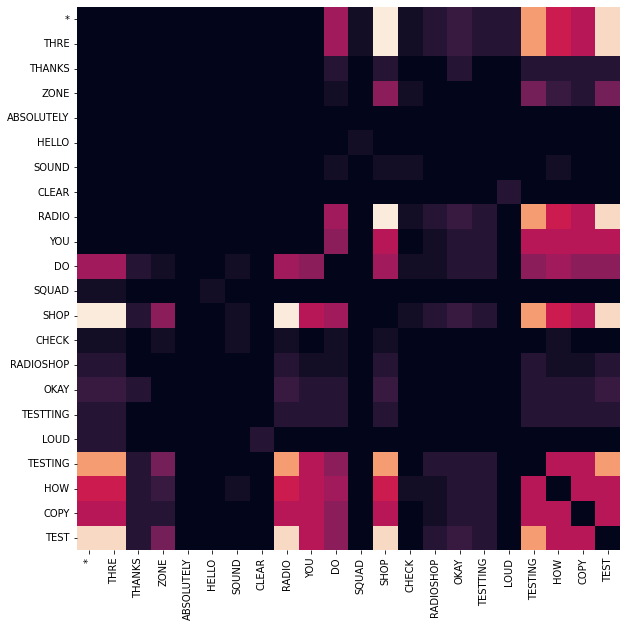

In [221]:
# matrix1 = words_heat_map(('ONE', 'TWO', 'THREE'),
#                         comb_dict[('ONE', 'TWO', 'THREE')])
matrix1 = words_heat_map(('ZERO', 'NINE'),
                        comb_dict[('ZERO', 'NINE')])

In [6]:
text_with_special_charc = []
for transcript in text:
    if '[' in transcript or '<' in transcript or '(' in transcript:
        text_with_special_charc.append(transcript)

In [7]:
# clean text
porter = nltk.PorterStemmer()
clean_text = []
for transcript in text:
    # remove those only have <>
    transcript = transcript.replace('<X>', '').replace('<x>', '')
    # remove text inside [] and ()
    transcript = re.sub('[\(\[].*?[\)\]]', '', transcript)
    # remove empty
    if transcript == '':
        continue
    # clean
    splited = [re.sub('[^a-zA-Z0-9]', '', word) for word in transcript.split(' ')]
    stemed = [porter.stem(word) for word in splited if len(word) != 0 and word != '']
    clean_text.append(' '.join(stemed))

In [8]:
# remove stopword
stopword_list = ['on', 'the', 'a', 'and', 'on', 'uh', 'in', 'to', 'at', 'that', 'for', 'is', 'with', 'of', 'oh', '', 'and']
second_clean_text = []
for transcript in clean_text:
    words = [word for word in transcript.split(' ') if word not in stopword_list]
    second_clean_text.append(' '.join(words))

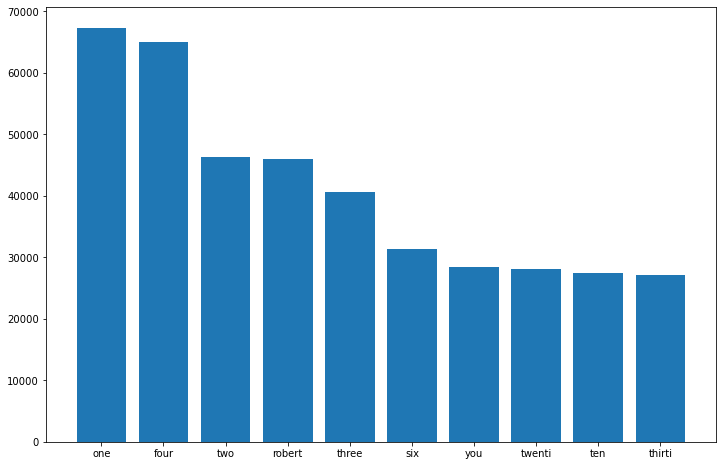

In [11]:
# 
word_dict = ' '.join(second_clean_text).split(' ')
freq = nltk.FreqDist(word_dict)
message_bag = pd.DataFrame(freq.most_common(), columns=['word_name', 'count'])
total_count = sum(message_bag['count'])
message_bag['tf'] = message_bag['count'] / total_count
plt.figure(figsize=(12, 8))
plt.bar(message_bag.head(10)['word_name'], message_bag.head(10)['count'])
plt.show()

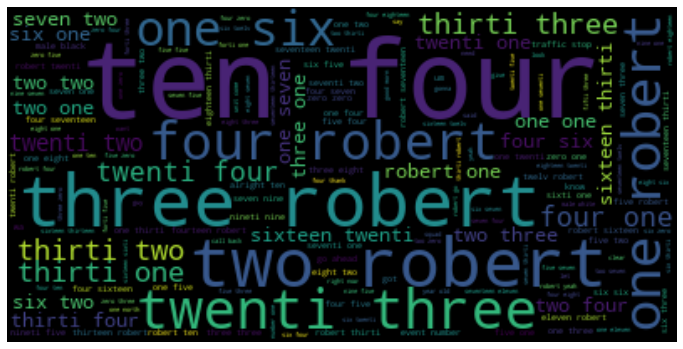

In [19]:
text = ' '.join(word_dict)
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
# use LDA
list_of_list_of_tokens = [line.split(' ') for line in second_clean_text]
dictionary_LDA = gensim.corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]
num_topics = 5
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics,
                                   id2word=dictionary_LDA,
                                   passes=4, alpha=[0.01]*num_topics,
                                   eta=[0.01]*len(dictionary_LDA.keys()))
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# detect combination of numbers


['radioshop test one two three four five five four three two one radio shop test',
 'one two one two',
 'unit come',
 'zone one citi five',
 'okay thank thi radio shop test how do you copi one two three four five',
 'five four three two one loud clear',
 'zero nine thirti five hour loud clear',
 'one two tre cuatro',
 'sixteen seven david zone one five citi wide five b five',
 'radioshop test one',
 'loud clear sir',
 'nine fourti nine',
 'uno do tre cuatro cinco loud clear',
 'radio shop test one two three four five',
 'five four three two one radio shop test',
 'loud clear one two three four five',
 'sixteen twenti four robert',
 'two four robert',
 'we found taxi driver it go be',
 'sixteen twenti one robert',
 'six two one robert',
 'suspic person seventi one hundr mason call say three male hoodi ride bike check car door one gray either gray or white hoodi other two are dark hoodieshead north bound',
 'ten four',
 'seven eleven',
 'eleven robert',
 'thirti minut',
 'seventeen thirt